We'll begin by gathering data spanning from 2009 to 2023 via the arXiv's OAI API. Our objective is to explore and identify any significant trends within this dataset.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import xml.etree.ElementTree as ET
import time
import numpy as np

for i in range(2009, 2024):
    # Specify the base URL of the OAI-PMH interface
    base_url = 'http://export.arxiv.org/oai2'

    # Specify the verb
    verb = 'ListRecords'

    # Specify the metadata format
    metadata_prefix = 'oai_dc'

    # Formulate the URL
    url = f'http://export.arxiv.org/oai2?verb=ListRecords&set=math&metadataPrefix=oai_dc&from={i}-01-01&until={i}-12-31'

    # An empty list to hold all the XML responses
    responses = []

    while url is not None:
        # Send the GET request
        response = requests.get(url)

        # If the request was successful, parse the data
        if response.status_code == 200:
            responses.append(response.text)
            root = ET.fromstring(response.text)
            token_element = root.find('.//{http://www.openarchives.org/OAI/2.0/}resumptionToken')
            if token_element is not None:
                token = token_element.text
                # Form the new url using the resumption token
                url = f'{base_url}?verb={verb}&resumptionToken={token}'
                print(token)
            else:
                url = None  # No more pages
        else:
            print(f'Request failed with status code {response.status_code}')
            url = None  # Exit the loop
        time.sleep(5)
    with open(f'math_{i}.pkl','wb') as f:
        pickle.dump(responses, f)

In [314]:
# Initialize an empty list and load the list for all years
arXiv_data=[]
for i in range(2009, 2024):
    # Load the list from the file
    with open(f'math_{i}.pkl', 'rb') as f:
        arXiv_data.append(pickle.load(f))

In [280]:
# namespace is used to avoid name conflicts.
namespaces = {'default':'http://www.openarchives.org/OAI/2.0/', 
              'oai_dc':'http://www.openarchives.org/OAI/2.0/oai_dc/',
              'dc':'http://purl.org/dc/elements/1.1/'}

In [281]:
def get_titles(list):
    titles = []
    for i in range(len(list)):
        root = ET.fromstring(list[i])
        for record in root.findall('default:ListRecords/default:record', namespaces):
            title = record.findall('default:metadata/oai_dc:dc/dc:title', namespaces)
            if len(title)>0:
                titles.append(title[0].text)
            else: titles.append(None)
    return titles

In [282]:
def get_descriptions(list):
    descriptions = []
    for i in range(len(list)):
        root = ET.fromstring(list[i])
        for record in root.findall('default:ListRecords/default:record', namespaces):
            description = record.findall('default:metadata/oai_dc:dc/dc:description', namespaces)
            if len(description)>0:
                descriptions.append(description[0].text)
            else: descriptions.append(None)
    return descriptions

In [283]:
def get_areas(list, subject):
    area_list = []
    for i in range(len(list)):
        root = ET.fromstring(list[i])
        for record in root.findall('default:ListRecords/default:record', namespaces):
            areas = record.findall('default:metadata/oai_dc:dc/dc:subject', namespaces)
            areas_for_this_subject = [area.text for area in areas 
                                            if subject in area.text]
            area_list.append(areas_for_this_subject)
    return area_list

In [284]:
def get_authors(list):
    authors = []
    for i in range(len(list)):
        root = ET.fromstring(list[i])
        for creator in root.findall('default:ListRecords/default:record', namespaces):
            author_set = creator.findall('default:metadata/oai_dc:dc/dc:creator', namespaces)
            authors.append([author.text for author in author_set])    
    return authors

In [285]:
#separate this given its unique characteristics
def get_dates(list):
    dates = []
    for i in range(len(list)):
        root = ET.fromstring(list[i])
        for record in root.findall('default:ListRecords/default:record', namespaces):
            date = record.findall('default:header/default:datestamp', namespaces)
            dates.append(date[0].text)
    return dates

In [286]:
# This function will create our desired DataFrame
def DataFrame_from_responses(list, subject):
    return pd.DataFrame({'authors':get_authors(list),
    'title':get_titles(list),
    'date':get_dates(list),
    'description':get_descriptions(list),
    'area':get_areas(list, subject)})

In [315]:
# Initialize an empty dictionary to hold the dataframes
df_dict = {}

# Loop over the years
for year in range(2009, 2024):
    # Create a dataframe and store it in the dictionary
    df_dict[year] = DataFrame_from_responses(arXiv_data[year-2009], 'Math')

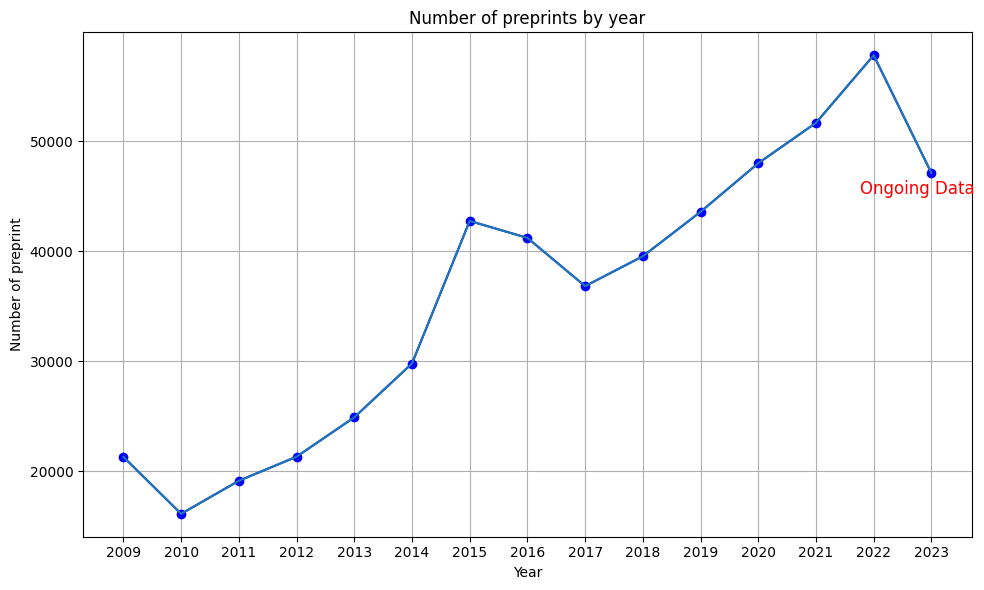

In [334]:
years = []
lengths = []

for year, df in df_dict.items():
    years.append(year)
    lengths.append(df.shape[0])

plt.figure(figsize=(10,6))
plt.plot(years, lengths, marker='o', linestyle='-', color='b')
plt.plot(years, lengths)
plt.title('Number of preprints by year')
plt.xlabel('Year')
plt.ylabel('Number of preprint')
plt.annotate('Ongoing Data', (years[-1], lengths[-1]), textcoords="offset points", xytext=(-10,-15), ha='center', fontsize=12, color='r')
plt.grid()
plt.tight_layout()
plt.xticks(np.arange(min(years), max(years) + 1, 1))
plt.show()

The volume of the preprints in math is increasing every year.
Let us compute the yearly average count of authors for each preprint by year.

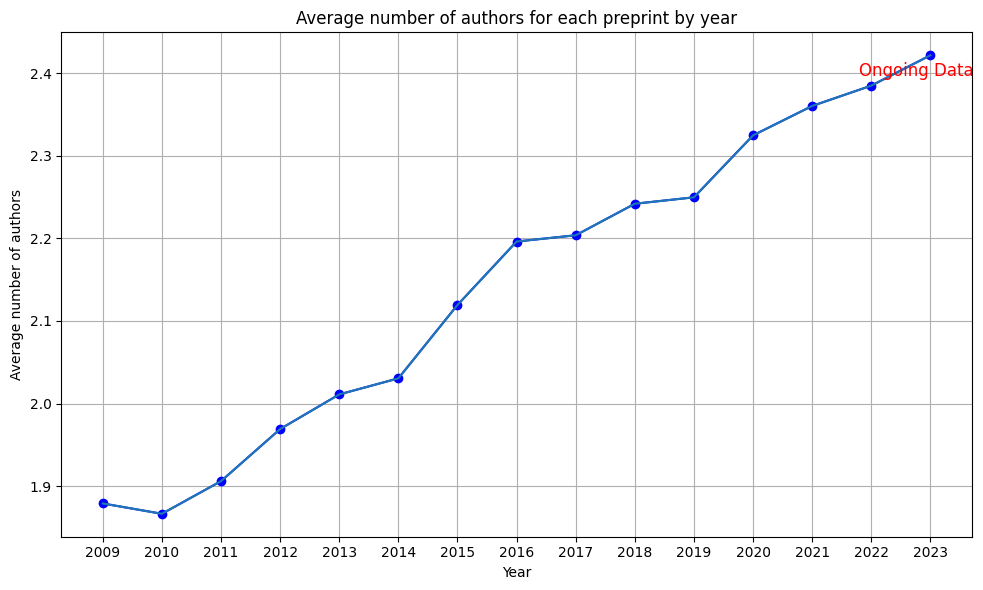

In [358]:
years=[]
avg_num_authors=[]

for year, df in df_dict.items():
    years.append(year)
    num_authors=df['authors'].apply(len)
    avg_num_authors.append(num_authors.mean())

plt.figure(figsize=(10,6))
plt.plot(years, avg_num_authors, marker='o', linestyle='-', color='b')
plt.plot(years, avg_num_authors)
plt.title('Average number of authors for each preprint by year')
plt.xlabel('Year')
plt.ylabel('Average number of authors')
plt.annotate('Ongoing Data', (years[-1], avg_num_authors[-1]), textcoords="offset points", xytext=(-10,-15), ha='center', fontsize=12, color='r')
plt.grid()
plt.tight_layout()
plt.xticks(np.arange(min(years), max(years) + 1, 1))
plt.show()

The increasing trend of collaboration in mathematics could account for the surge in preprint production, as seen in the prior chart.

In [359]:
area_counts_by_year = []
for i in range(2009, 2024):
    # Explode the 'area' column
    exploded_df = df_dict[i].explode('area')

    # Count the frequency of each area
    area_counts = exploded_df['area'].value_counts()

    # This will count the number of subject areas in data
    for i in range(len(area_counts)):
        if "Mathematics" in area_counts.index[i]:
            area_counts.index = area_counts.index.str.replace("Mathematics - ", "")
            
    # create a boolean mask where True for rows whose index does not start with a number
    mask = ~area_counts.index.str[0].str.isdigit()

    # apply the mask to the DataFrame. This will delete the ones with MSC classification code
    area_counts_by_year.append(area_counts[mask])

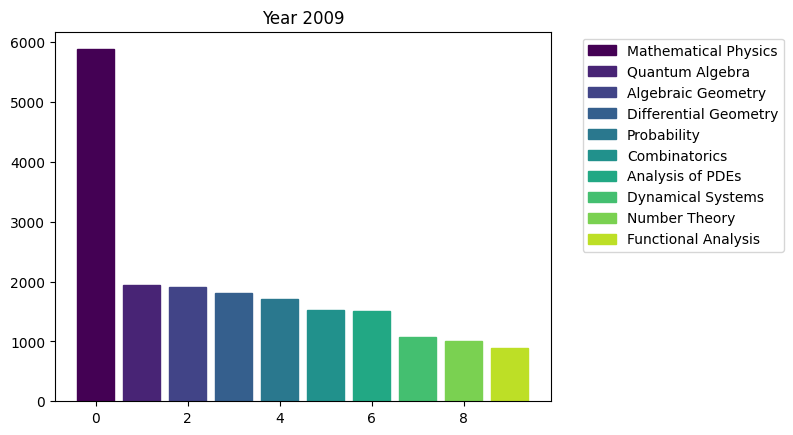

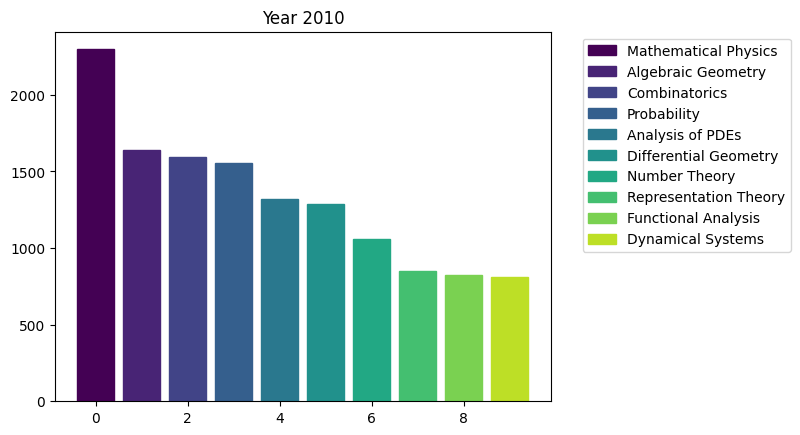

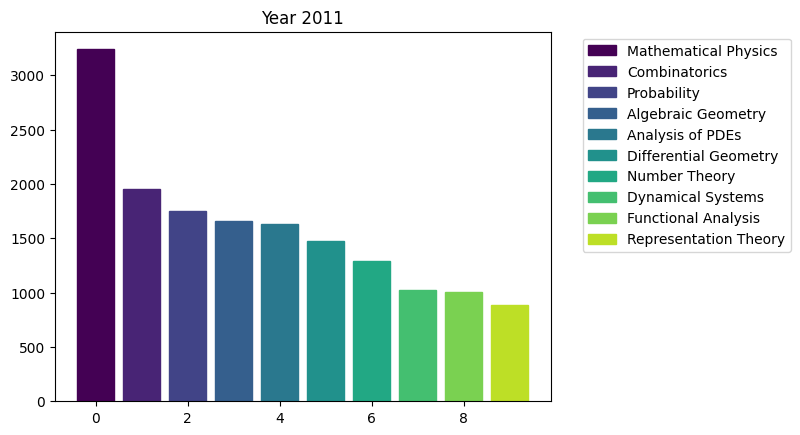

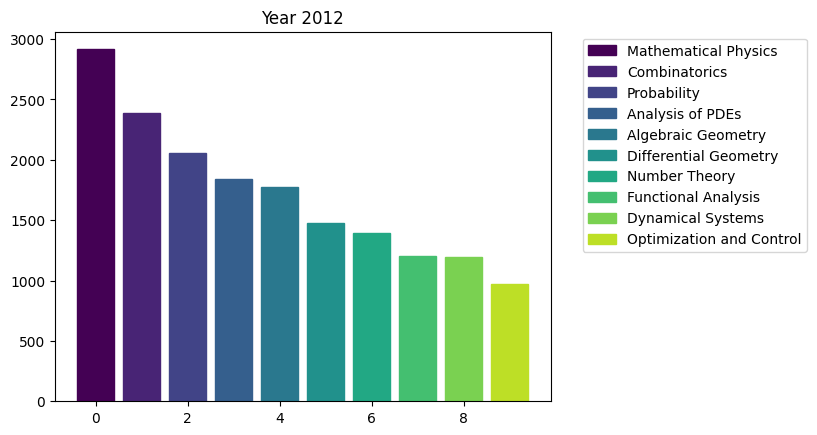

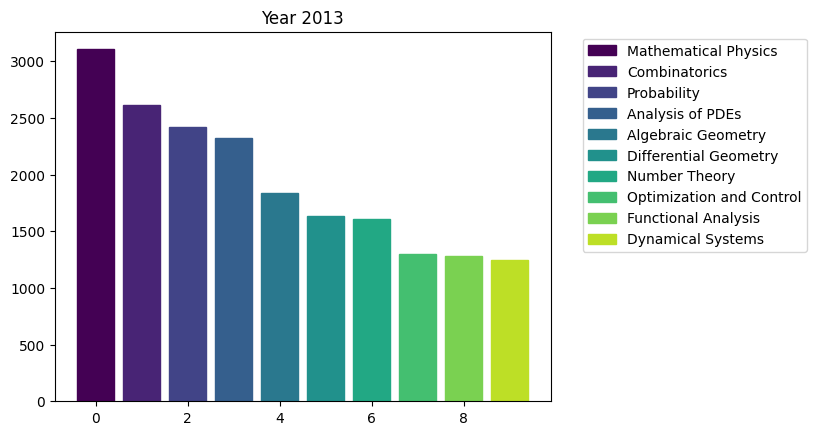

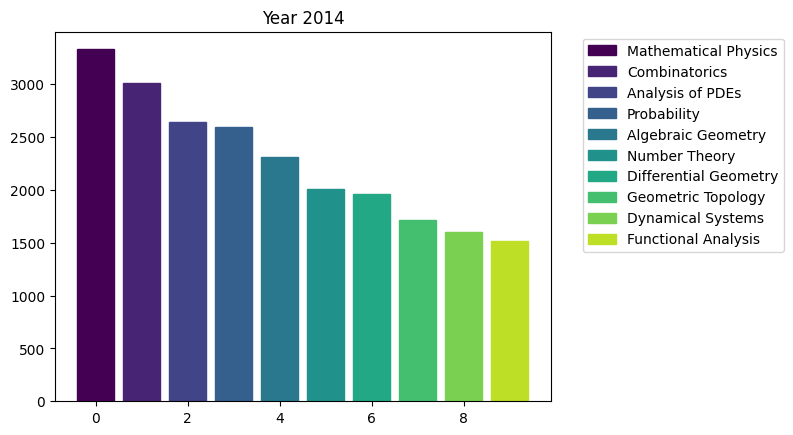

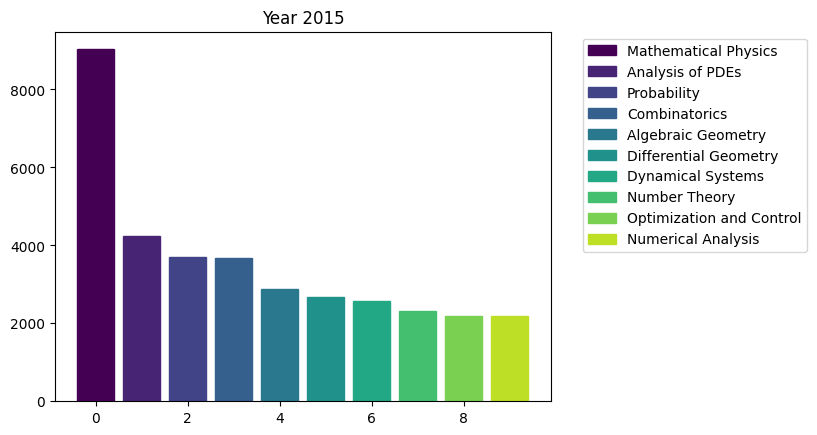

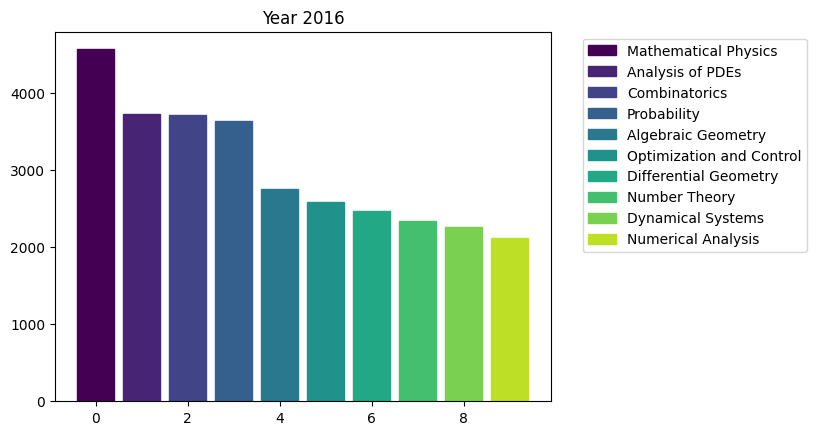

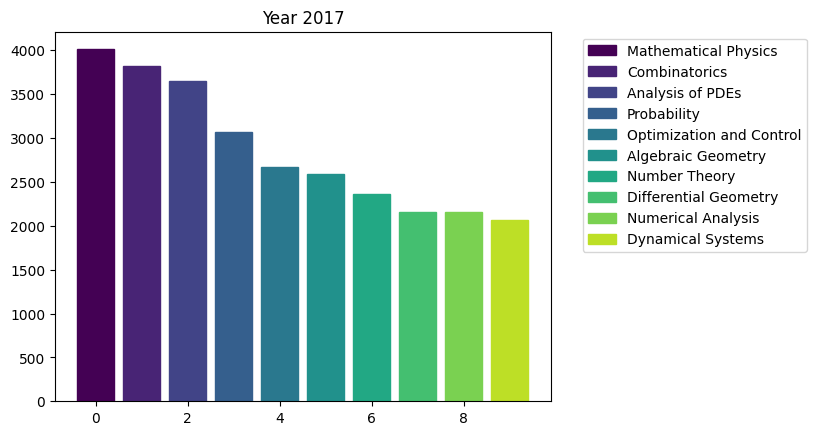

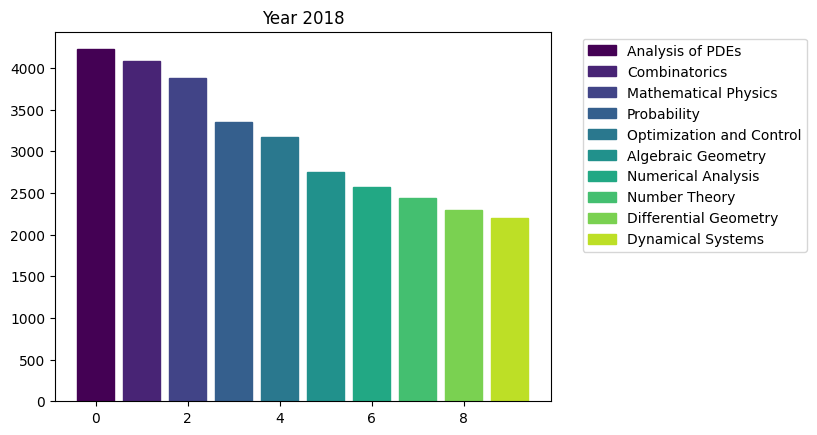

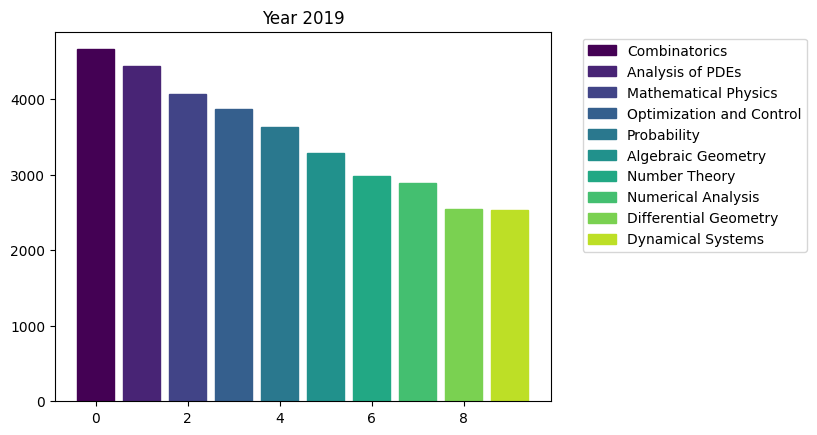

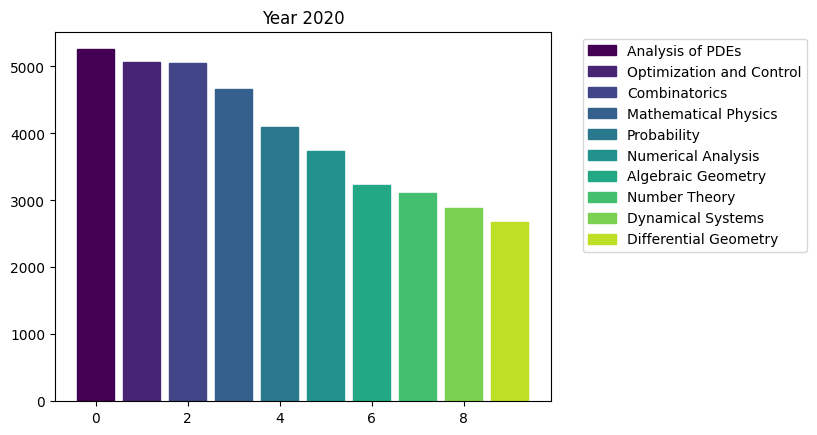

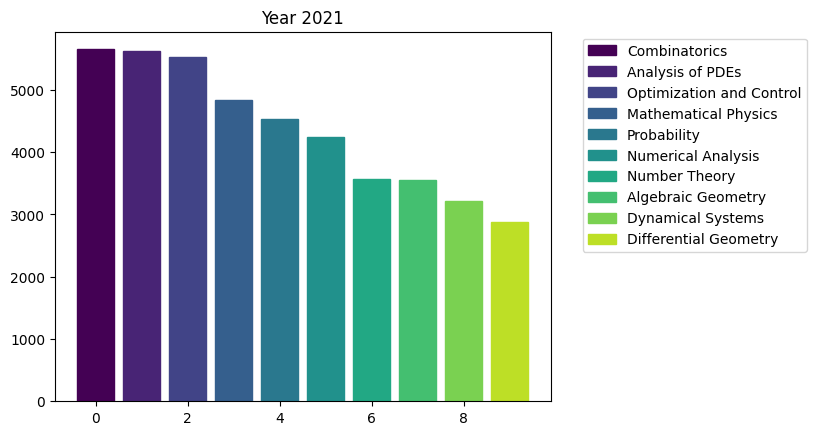

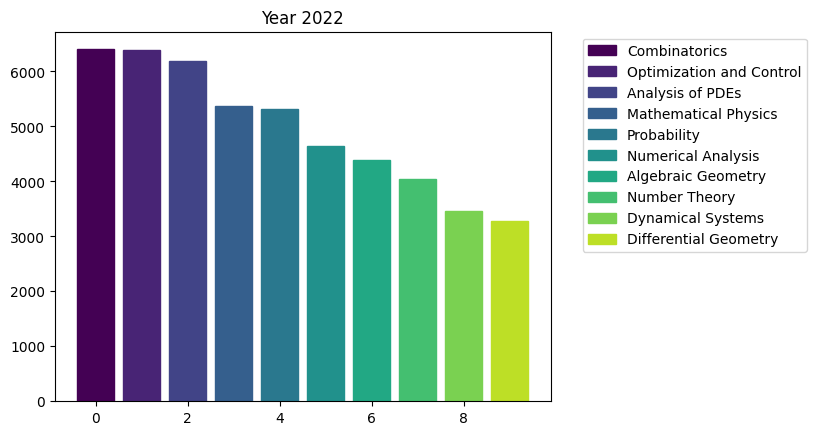

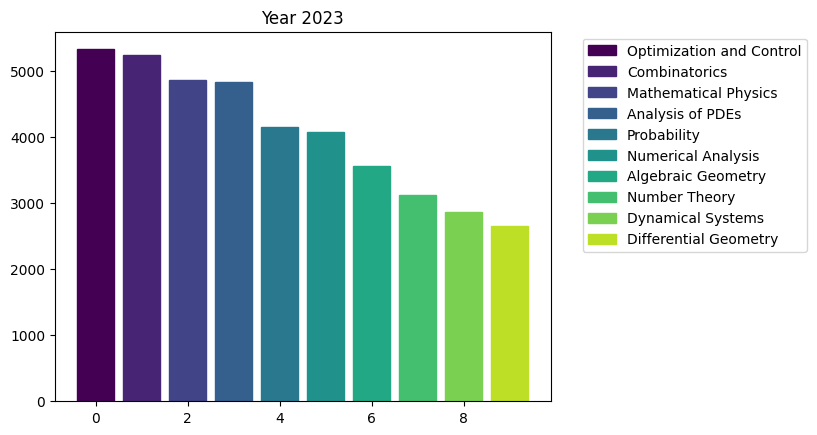

In [363]:
# Let us plot the number of areas of research for each year
for i in range(15):
    fig, ax = plt.subplots()

    bars = ax.bar(range(10), area_counts_by_year[i].values[:10])  # plot bars

    for j in range(10):
        bars[j].set_color(plt.cm.viridis(j / 10.))  # set a different color for each bar
    plt.title(f'Year {i+2009}')
    ax.legend(bars, area_counts_by_year[i].index[:10], bbox_to_anchor=(1.05, 1), loc='upper left')  # add a legend outside of the plot
    plt.show()

We can see the rapid surge of Optimization and Control community. 

In [415]:
years = range(2009, 2024)
OC = [area_counts_by_year[i]['Optimization and Control'] for i in range(15)]

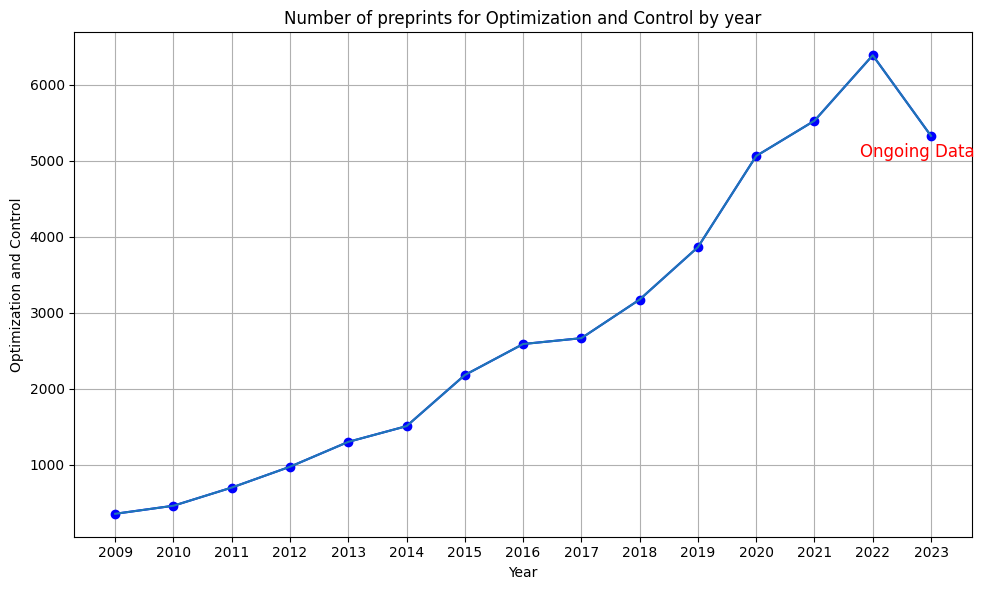

In [416]:
plt.figure(figsize=(10,6))
plt.plot(years, OC, marker='o', linestyle='-', color='b')
plt.plot(years, OC)
plt.title('Number of preprints for Optimization and Control by year')
plt.xlabel('Year')
plt.ylabel('Optimization and Control')
plt.annotate('Ongoing Data', (years[-1], OC[-1]), textcoords="offset points", xytext=(-10,-15), ha='center', fontsize=12, color='r')
plt.grid()
plt.tight_layout()
plt.xticks(np.arange(min(years), max(years) + 1, 1))
plt.show()

We can also compare the average slope, for example between Optimization/Control and Algebraic Geometry.

In [423]:
OC = (area_counts_by_year[13]['Optimization and Control']
      -area_counts_by_year[0]['Optimization and Control'])/14

AG = (area_counts_by_year[13]['Algebraic Geometry']
      -area_counts_by_year[0]['Algebraic Geometry'])/14

print(f'Average increasing rate of Optimization community is {round(OC, 2)} and that of Algebraic Geometry community is {round(AG, 2)}.')

Average increasing rate of Optimization community is 430.79 and that of Algebraic Geometry community is 177.14.


In [ ]:
import re
import string

def clean_and_split(s):
    #'tr' is an object that will assign blank space to each
    # punctuation symbol
    tr=str.maketrans(string.punctuation," "*len(string.punctuation))
    s=s.lower().translate(tr)
    # \r\n and \n are line breaks; we substitute with blank space.
    s=re.sub('(\r\n)+',' ',s)
    s=re.sub('(\n)+',' ',s)
    # replace all multiple spaces into a single space.
    s=re.sub(' +',' ',s.strip())
    s=s.split(' ')
    return s    

In [378]:
# For all descriptions, we split all words and count them.
list_of_words = df_dict[2009]['description'].dropna().apply(clean_and_split)
list_of_words_flattened = [a for b in list_of_words for a in b]
word_counts_1=collections.Counter(list_of_words_flattened)

# We are interested in the change of keywords in 15 years so we collect words for year 2023 as well
list_of_words = df_dict[2023]['description'].dropna().apply(clean_and_split)
list_of_words_flattened = [a for b in list_of_words for a in b]
word_counts_2=collections.Counter(list_of_words_flattened)

[nltk_data] Downloading package brown to
[nltk_data]     /Users/minseoksong/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/minseoksong/nltk_data...
[nltk_data]   Package words is already up-to-date!


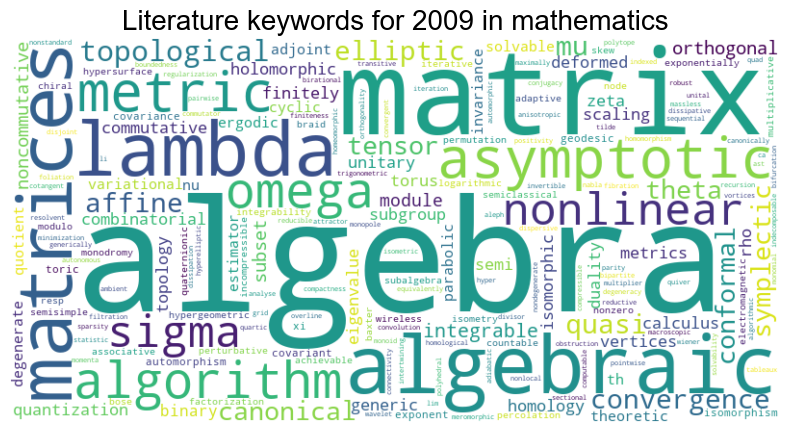

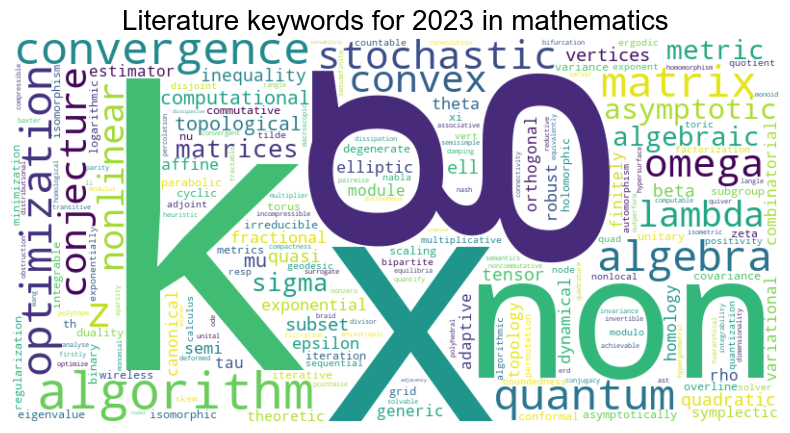

In [401]:
nltk.download('brown')
nltk.download('words')

# Calculate frequencies of each word in the Brown corpus
fdist_brown = nltk.FreqDist(w.lower() for w in brown.words())

# Create a set of English words
english_words = set(words.words())

# Extract only the words that are in the dictionary
# and used 1000 times more frequently in my data than in the Brown corpus.
unusually_frequent_words_1 = {word: count for word, count in word_counts_1.items() 
                              if word in english_words and count > 1000 * fdist_brown[word]}
unusually_frequent_words_2 = {word: count for word, count in word_counts_2.items() 
                              if word in english_words and count > 1000 * fdist_brown[word]}

# Create a WordCloud object
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unusually_frequent_words_1)
wordcloud_2 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unusually_frequent_words_2)

# Plot the word cloud
def wordcloud(data, year):
    plt.figure(figsize=(10, 5))
    plt.imshow(data, interpolation='bilinear')
    plt.title(f'Literature keywords for {year} in mathematics', fontsize=20, fontname = 'Arial')
    plt.axis('off')
    plt.show()

wordcloud(wordcloud_1, 2009)
wordcloud(wordcloud_2, 2023)

Some words 'g,' 'k,' and 'x' in year 2023, even if less frequently used, are awkward, so we may delete them.

In [397]:
del unusually_frequent_words_2['g']
del unusually_frequent_words_2['k']
del unusually_frequent_words_2['x']

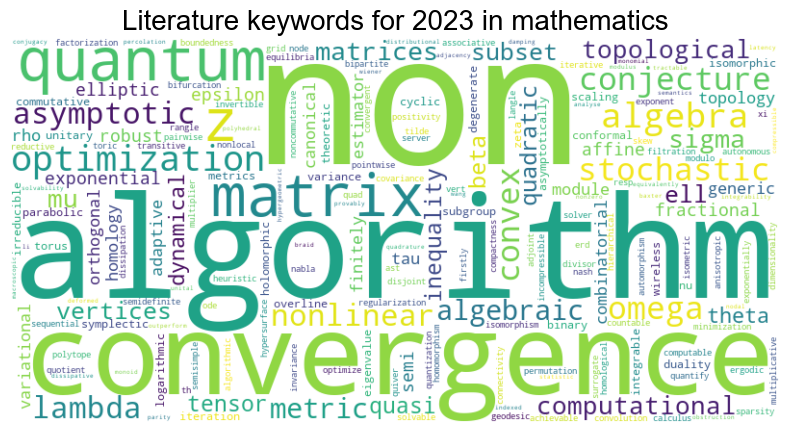

In [398]:
# We display the keywords for 2023 as before.
wordcloud_2 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unusually_frequent_words_2)
wordcloud(wordcloud_2, 2023)

The prominence of 'algorithm' as a keyword is likely a reflection of the growing interest and investment in the optimization and control community, as evidenced by previous bar graphs depicting research areas.